In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Pneumonia Detection with Transfer Learning**

Detecting pneumonia in pediatric chest X-ray images using VGG16, InceptionV3, and Xception pre-trained models. Dataset includes 5,863 images categorized into Pneumonia and Normal.

## Models
### VGG16
- Simple and effective CNN with 16 weight layers.
- Excels at capturing intricate patterns.
- Straightforward design for easy implementation.
- Suitable for pneumonia detection by extracting relevant features from chest X-ray images.

### InceptionV3
- Efficient architecture with inception modules.
- Uses multiple filter sizes concurrently.
- Balances computational efficiency with high accuracy.
- Well-suited for complex tasks like pneumonia detection.
- Ability to handle diverse features enhances effectiveness in medical image analysis.

### Xception
- Extension of Inception with depthwise separable convolutions.
- Focuses on efficient capture of spatial and channel-wise dependencies.
- Strength lies in extracting intricate spatial features.
- Suitable for tasks where fine details, like pneumonia-related patterns, are crucial.


## Implementation
Code uses TensorFlow and Keras for training and fine-tuning. Evaluation metrics include accuracy, precision, recall, and F1-score.

## Conclusion
Comparing model performance to guide further research in pneumonia detection.


# **All Imports**

In [2]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
# main_path = "../input/labeled-chest-xray-images/chest_xray"
main_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [5]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [6]:
len(train_list)

5216

## **Data Exploration**

### **Train Data**

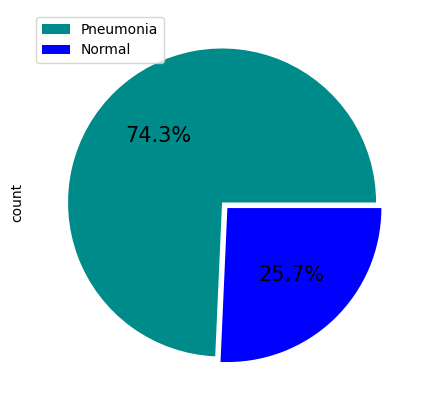

In [7]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

### **Test Data**

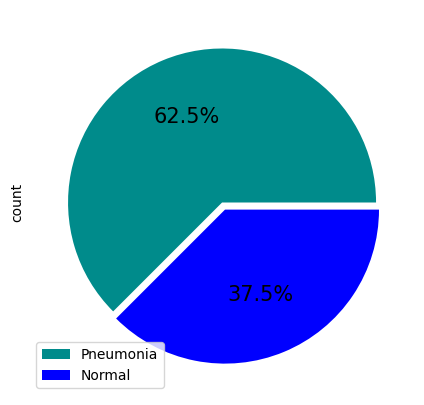

In [8]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

## **Image Data Preprocessing and Augmentation with Keras**


In [9]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [10]:

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


## **Transfer Learning**

#### **Callbacks**

In [11]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

# **MODELS**

# 1.VGG16 Model

In [12]:
base_model_vgg16 = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model_vgg16.trainable = False

def get_pretrained_vgg16():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model_vgg16(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    return model








58889256/58889256 [==============================] - 0s 0us/step


In [13]:
keras.backend.clear_session()

model_pretrained = get_pretrained_vgg16()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [14]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 157s 1s/step - loss: 0.6563 - binary_accuracy: 0.6045 - val_loss: 0.5593 - val_binary_accuracy: 0.7433 - lr: 5.0000e-05
Epoch 2/50
130/130 [==============================] - 107s 822ms/step - loss: 0.5373 - binary_accuracy: 0.7428 - val_loss: 0.5219 - val_binary_accuracy: 0.7433 - lr: 5.0000e-05
Epoch 3/50
130/130 [==============================] - 108s 826ms/step - loss: 0.5045 - binary_accuracy: 0.7430 - val_loss: 0.4880 - val_binary_accuracy: 0.7433 - lr: 5.0000e-05
Epoch 4/50
130/130 [==============================] - 109s 835ms/step - loss: 0.4711 - binary_accuracy: 0.7476 - val_loss: 0.4580 - val_binary_accuracy: 0.7490 - lr: 5.0000e-05
Epoch 5/50
130/130 [==============================] - 109s 833ms/step - loss: 0.4421 - binary_accuracy: 0.7605 - val_loss: 0.4291 - val_binary_accuracy: 0.7826 - lr: 5.0000e-05
Epoch 6/50
130/130 [==============================] - 108s 831ms/step - loss: 0.4120 - binary_accuracy: 0.7843 - val_l

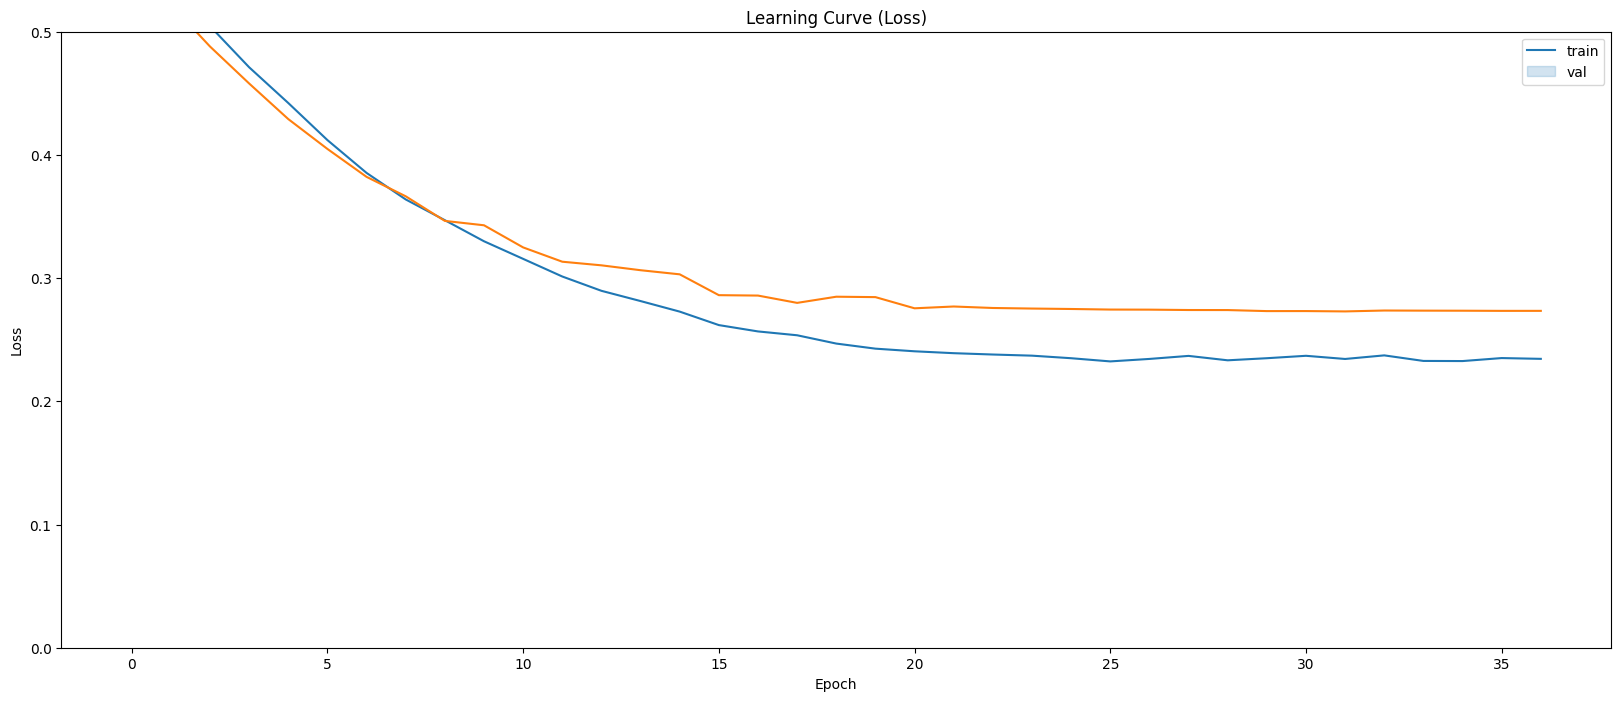

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

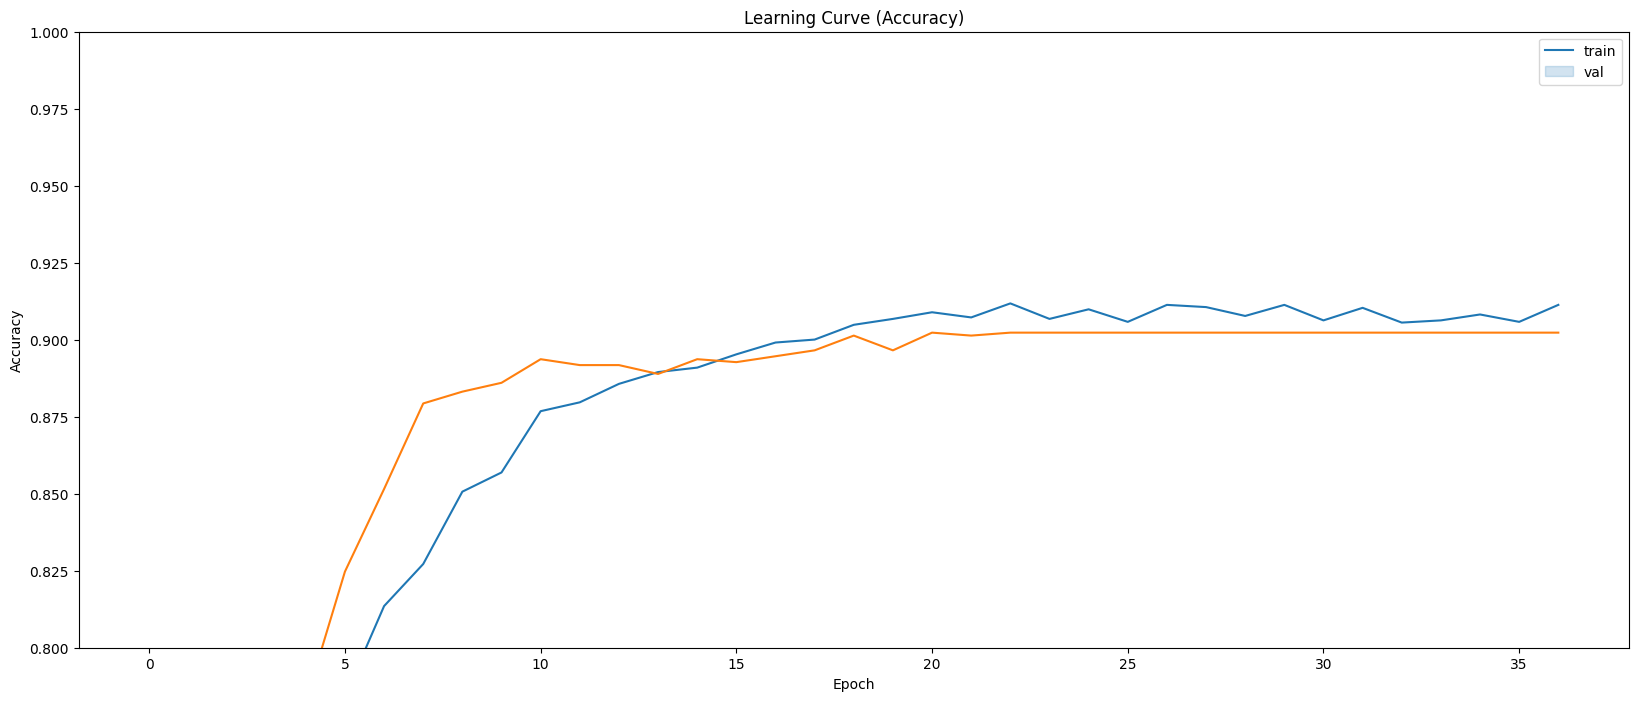

In [16]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [17]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.27297642827033997
Val accuracy: 0.9022988677024841


In [18]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.36162108182907104
Test accuracy: 0.8365384340286255


In [25]:
base_model_vgg16.trainable = True

# Freeze all layers except for the
for layer in base_model_vgg16.layers[:-4]:
    layer.trainable = False

In [26]:
for layer_number, layer in enumerate(base_model_vgg16.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [27]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [28]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [29]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8365384615384616


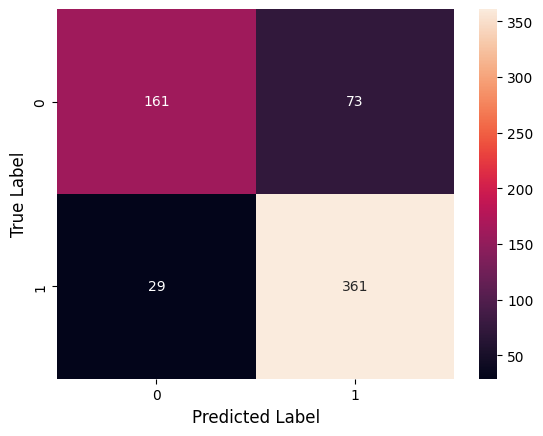

In [30]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [31]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       234
           1       0.83      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624



ROC_AUC:  0.9225838264299802


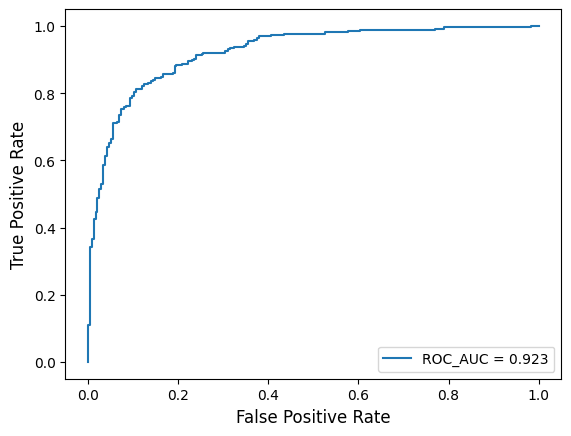

In [32]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

# 2. ResNet

In [34]:
base_model_resnet = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model_resnet.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model_resnet(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [35]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [36]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 141s 1s/step - loss: 0.3338 - binary_accuracy: 0.8641 - val_loss: 0.2186 - val_binary_accuracy: 0.9157 - lr: 5.0000e-05
Epoch 2/50
130/130 [==============================] - 124s 954ms/step - loss: 0.1865 - binary_accuracy: 0.9355 - val_loss: 0.1510 - val_binary_accuracy: 0.9483 - lr: 5.0000e-05
Epoch 3/50
130/130 [==============================] - 124s 949ms/step - loss: 0.1585 - binary_accuracy: 0.9396 - val_loss: 0.1321 - val_binary_accuracy: 0.9483 - lr: 5.0000e-05
Epoch 4/50
130/130 [==============================] - 123s 941ms/step - loss: 0.1429 - binary_accuracy: 0.9485 - val_loss: 0.1233 - val_binary_accuracy: 0.9511 - lr: 5.0000e-05
Epoch 5/50
130/130 [==============================] - 123s 942ms/step - loss: 0.1289 - binary_accuracy: 0.9518 - val_loss: 0.1471 - val_binary_accuracy: 0.9454 - lr: 5.0000e-05
Epoch 6/50
130/130 [==============================] - 122s 937ms/step - loss: 0.1269 - binary_accuracy: 0.9535 - val_l

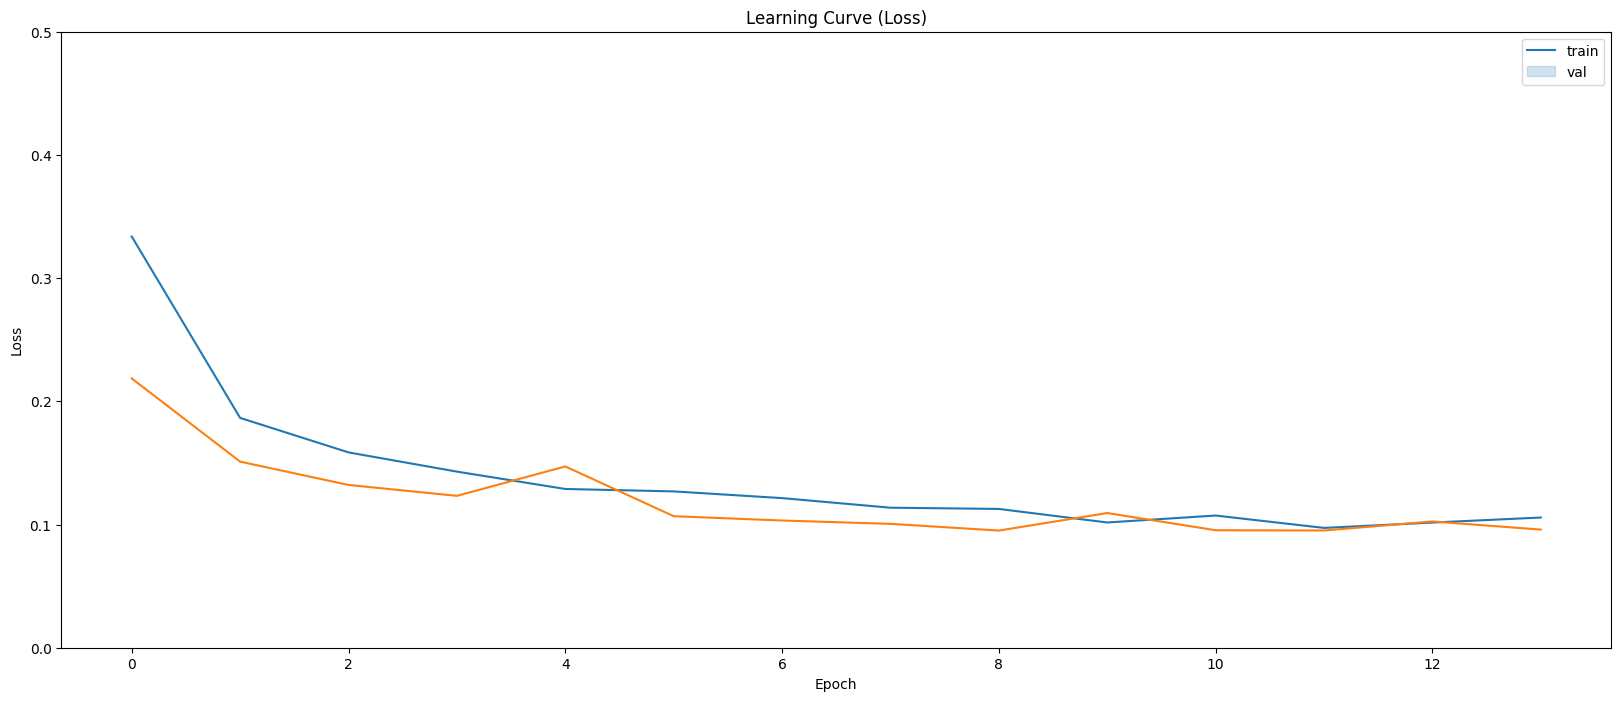

In [37]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

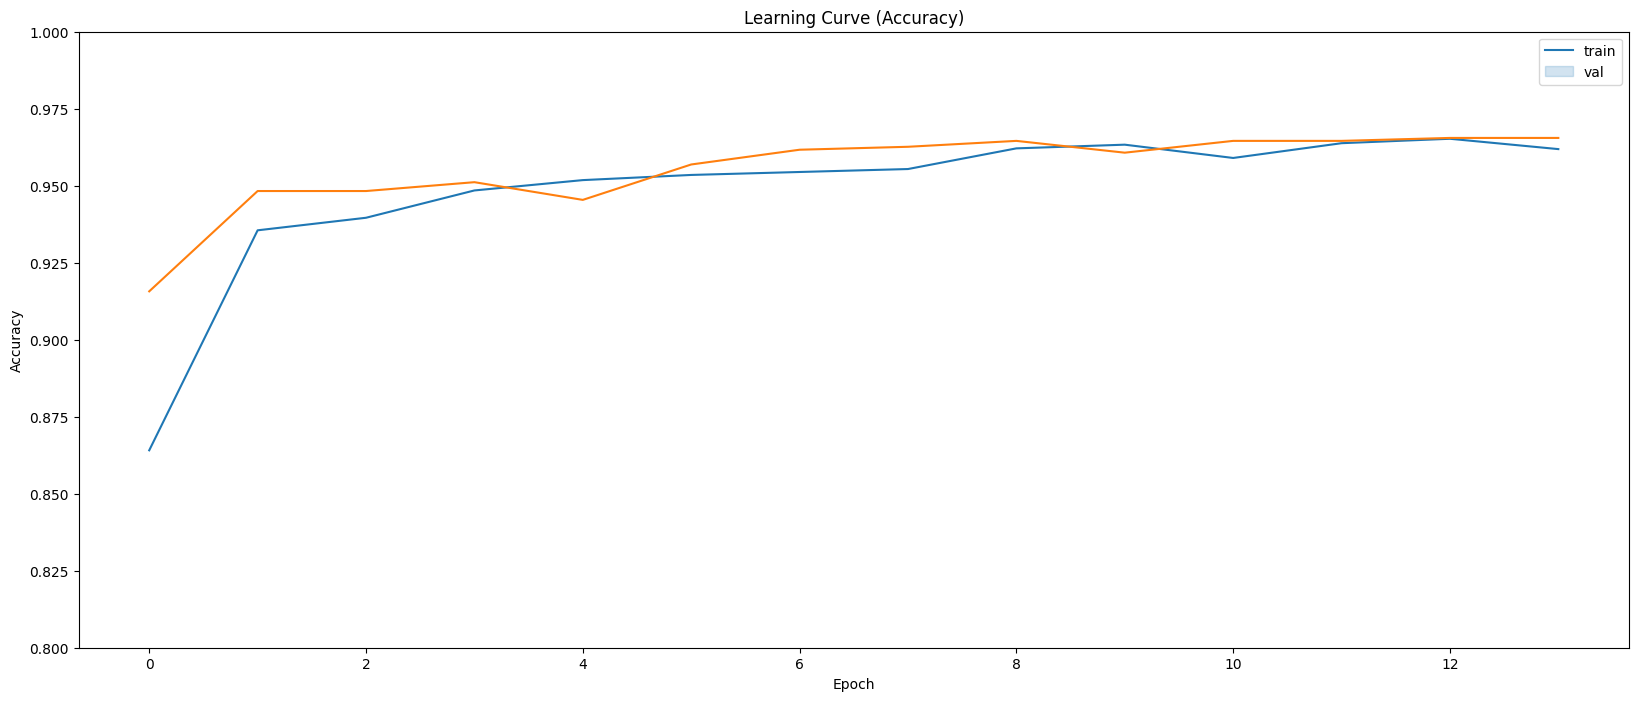

In [38]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [39]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.09510070830583572
Val accuracy: 0.9645593762397766


In [40]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4902563691139221
Test accuracy: 0.8317307829856873


In [41]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [42]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8317307692307693


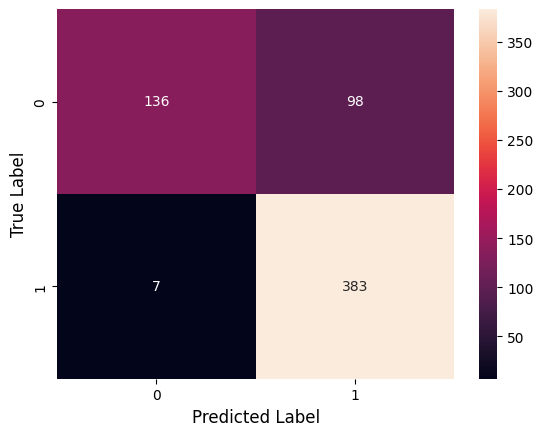

In [43]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [44]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.95      0.58      0.72       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624



ROC_AUC:  0.9425816348893272


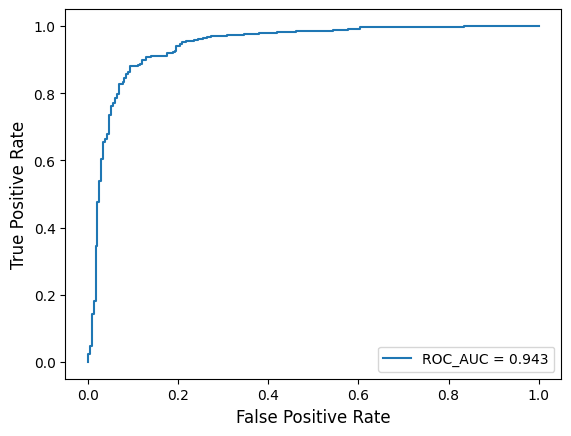

In [45]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

# Model Performance Summary

## VGG16 Model:
**Overall Inference:** The VGG16 model demonstrates strong performance, particularly in correctly identifying positive cases (pneumonia). It achieves high precision and recall for the positive class.

## ResNet152V2 Model:
**Overall Inference:** The ResNet152V2 model excels in correctly identifying positive cases (pneumonia) with impressive precision and recall. However, it exhibits a lower recall for the negative class compared to VGG16.

## General Observations:
- Both models showcase comparable accuracy, with VGG16 slightly outperforming ResNet152V2.
- The choice between the two models may depend on specific requirements and the importance of precision or recall for the given task.

These insights provide a concise summary of the strengths and areas for improvement for each model, assisting in informed decision-making.
